# Time-frequency analysis
## Evoked 

We can create ERPs from the Epochs object by calling the [epochs.average()](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.average) function. 

Visit MNE-Python documentation for tutorials related to ERPs [here](https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html). 

This is the part of the analysis where we can exlude incorrect answers, merging conditions or selecting only a subset of channels (e.g. skipping frontal channels close to the forehead). 


TODO: plot_joint() and GFP could be interesting, ROIs

In [2]:
import os
import mne
import numpy as np

%matplotlib qt

In [4]:
# Read epochs
epochs_path = '/Volumes/crnl-memo-hd/TMS_rewiring/preprocessed/epochs_asrt'
epochs_filename = '30_E_Day1_ICA_autoreject_ransac-epo.fif.gz'


epochs = mne.read_epochs(os.path.join(epochs_path, epochs_filename), preload=False)

Reading /Volumes/crnl-memo-hd/TMS_rewiring/preprocessed/epochs_asrt/30_E_Day1_ICA_autoreject_ransac-epo.fif.gz ...
    Found the data of interest:
        t =    -250.00 ...     750.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
Replacing existing metadata with 6 columns
1561 matching events found
No baseline correction applied
0 projection items activated


#### Filtering incorrect answers

Based on the metadata we can filter out stimuli that are followed by an incorrect answer.

In [5]:
epochs_correct_answers = epochs["answer == 'correct'"]

#### Equalizing trial counts per condition

Based on the metadata we can merge trials to have only two groups: H, L.
Then, we can equalize trial counts for the groups.

In [ ]:
# Do we need to equalize event counts??
epochs_correct_answers.equalize_event_counts?

In [6]:
stimuli_L = np.unique(epochs.metadata.loc[epochs.metadata['triplet'] == 'L', 'id']).tolist()
stimuli_H = np.unique(epochs.metadata.loc[epochs.metadata['triplet'] == 'H', 'id']).tolist()

epochs_correct_answers.events = mne.merge_events(epochs_correct_answers.events,
                                                 stimuli_L,
                                                 12,
                                                 replace_events=True)

epochs_correct_answers.events = mne.merge_events(epochs_correct_answers.events,
                                                 stimuli_H,
                                                 10,
                                                 replace_events=True)

# operates inplace
epochs_correct_answers.equalize_event_counts(['12', '10'])

Dropped 660 epochs: 6, 11, 14, 15, 16, 17, 18, 19, 22, 23, 26, 29, 32, 33, 42, 43, 44, 47, 48, 51, 54, 55, 58, 59, 60, 61, 64, 67, 76, 79, 80, 81, 82, 85, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 102, 105, 106, 107, 108, 111, 112, 113, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 134, 135, 136, 141, 142, 149, 152, 153, 154, 157, 160, 161, 164, 171, 172, 173, 174, 175, 176, 181, 182, 183, 184, 191, 192, 195, 196, 197, 198, 201, 202, 203, 208, 211, 212, 213, 214, 215, 216, 217, 220, 221, 228, 235, 236, 237, 238, 239, 242, 243, 246, 247, 248, 249, 250, 259, 262, 263, 264, 265, 266, 267, 268, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 286, 289, 290, 291, 292, 293, 294, 295, 296, 299, 300, 301, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 337, 338, 339, 340, 341, 342, 343, 348, 349, 350, 351, 352, 353, 354, 355, 364, 365, 366, 369, 370, 371, 372, 375, 376, 385, 386, 389, 398, 399, 400, 401, 402, 405, 406, 407, 408, 409, 410, 415, 416, 417, 418, 419, 420, 425, 426, 

(<EpochsFIF |  782 events (all good), -0.25 - 0.75 sec, baseline [-0.25, 0] sec, ~94 kB, data not loaded, with metadata,
  '10': 391
  '11': 0
  '12': 391
  '14': 0
  '15': 0
  '16': 0>,
 array([   6,   11,   14,   15,   16,   17,   18,   19,   22,   23,   26,
          29,   32,   33,   42,   43,   44,   47,   48,   51,   54,   55,
          58,   59,   60,   61,   64,   67,   76,   79,   80,   81,   82,
          85,   88,   89,   90,   91,   94,   95,   96,   97,   98,   99,
         102,  105,  106,  107,  108,  111,  112,  113,  116,  117,  120,
         121,  122,  123,  124,  125,  126,  127,  134,  135,  136,  141,
         142,  149,  152,  153,  154,  157,  160,  161,  164,  171,  172,
         173,  174,  175,  176,  181,  182,  183,  184,  191,  192,  195,
         196,  197,  198,  201,  202,  203,  208,  211,  212,  213,  214,
         215,  216,  217,  220,  221,  228,  235,  236,  237,  238,  239,
         242,  243,  246,  247,  248,  249,  250,  259,  262,  263,  264,

In [46]:
# We can also equalize on the Evoked level (fairly close)
evoked_H = epochs_correct_answers["triplet == 'H'"].average()
evoked_L = epochs_correct_answers["triplet == 'L'"].average()


evoked_combined = mne.combine_evoked([evoked_H, evoked_L], weights='nave')

print(f'N(H):{evoked_H.nave} + N(L):{evoked_L.nave} = {evoked_H.nave+evoked_L.nave}  ~= N(H+L)= {evoked_combined.nave}')

N(H):391 + N(L):391 = 782  ~= N(H+L)=781.9999999999999


#### Selecting a subset of channels

There are some frontal channels that are generally noisier than other channels (closer to the forehead), 
it is best to skip them before calculating ERP or power. 

In addition, we can reduce computation time with picking only a subset of channels.

In [8]:
ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]

epochs_evoked = epochs_correct_answers.copy().load_data().pick_channels(ch_names, ordered=True)


Loading data for 782 events and 501 original time points ...


In [ ]:
# uncomment to plot the locations of the sensors on the head model
# epochs_evoked.plot_sensors(show_names=True)

In [47]:
evoked_H = epochs_evoked["triplet == 'H'"].average()
evoked_L = epochs_evoked["triplet == 'L'"].average()
#evoked_e_2_H = epochs_evoked["epoch == 2 & triplet == 'H'"].average()

#### Showing signal traces

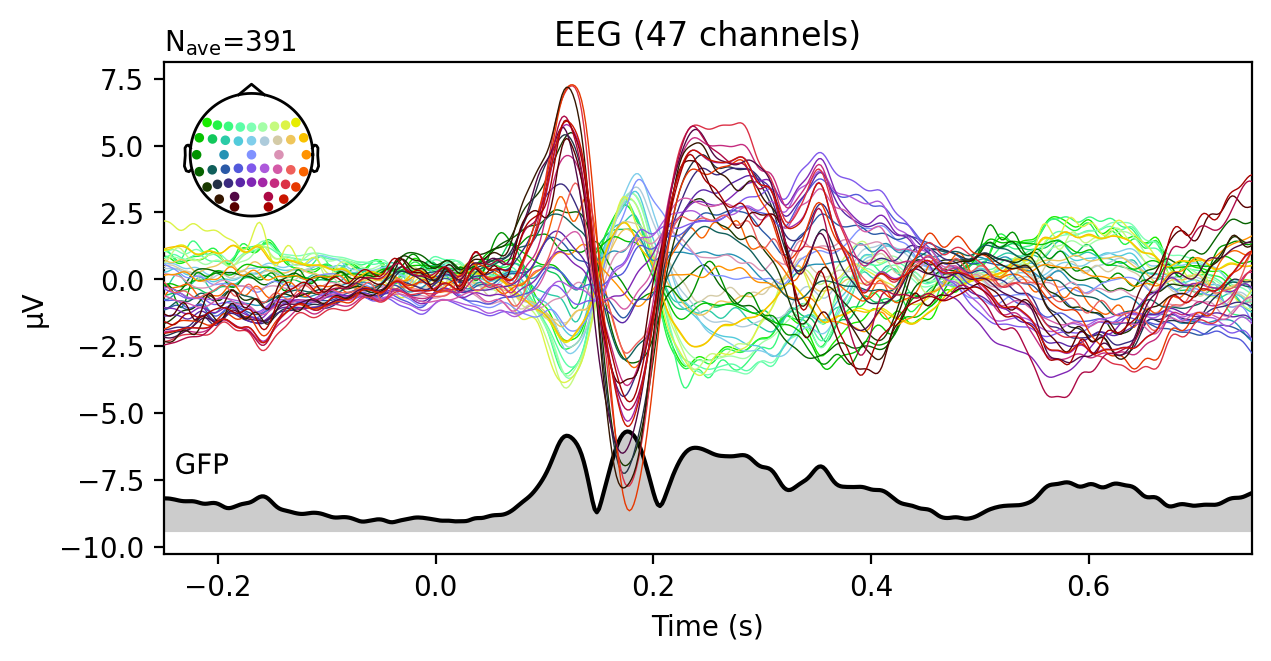

In [49]:
evoked_H.detrend().plot(picks='eeg', spatial_colors=True, gfp=True)

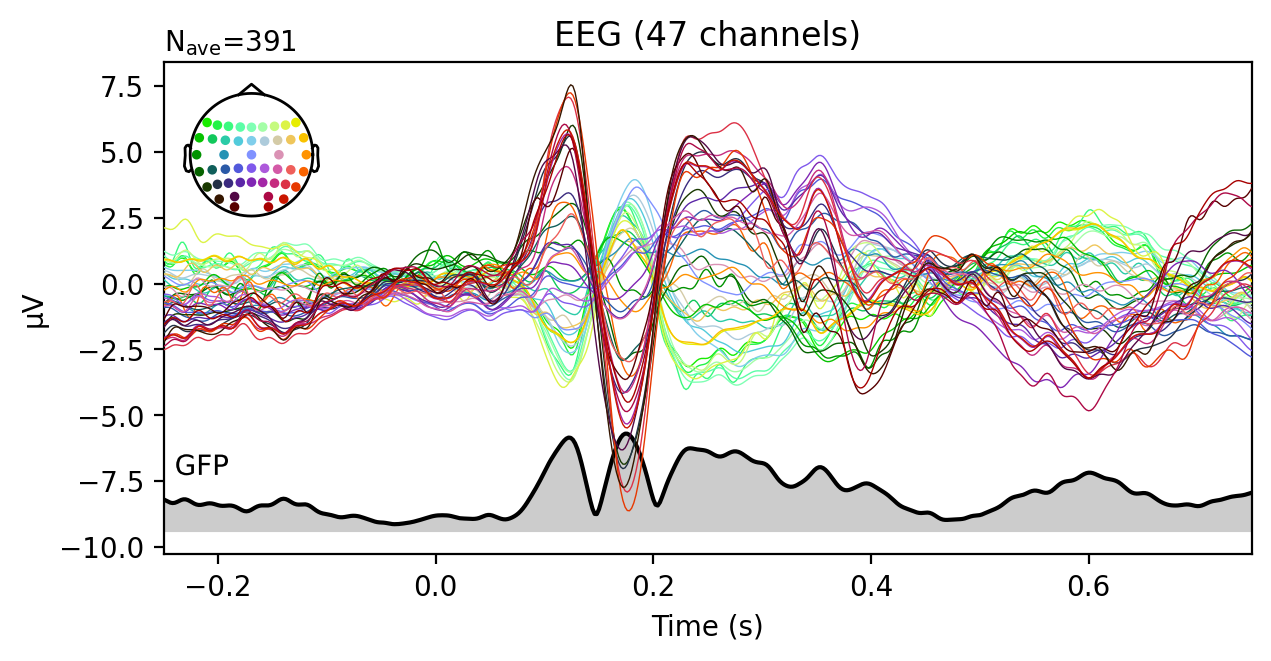

In [50]:
evoked_L.detrend().plot(picks='eeg', spatial_colors=True, gfp=True)

In [62]:
# Plot with respect to epochs
fig, ax = plt.subplots(5, 1, sharey=True, sharex=True)
for epoch_num in range(5):
    evoked_epoch_H = epochs_evoked[f"epoch == {epoch_num + 1} & triplet == 'H'"].crop(tmin=0.0,tmax=0.3).average()
    evoked_epoch_H.detrend().plot(picks='eeg',
                                  spatial_colors=True,
                                  gfp=True,
                                  show=False,
                                  axes=ax[epoch_num],
                                  titles='',
                                  window_title='')

fig.show()

#### Plotting topographies

No projector specified for this dataset. Please consider the method self.add_proj.


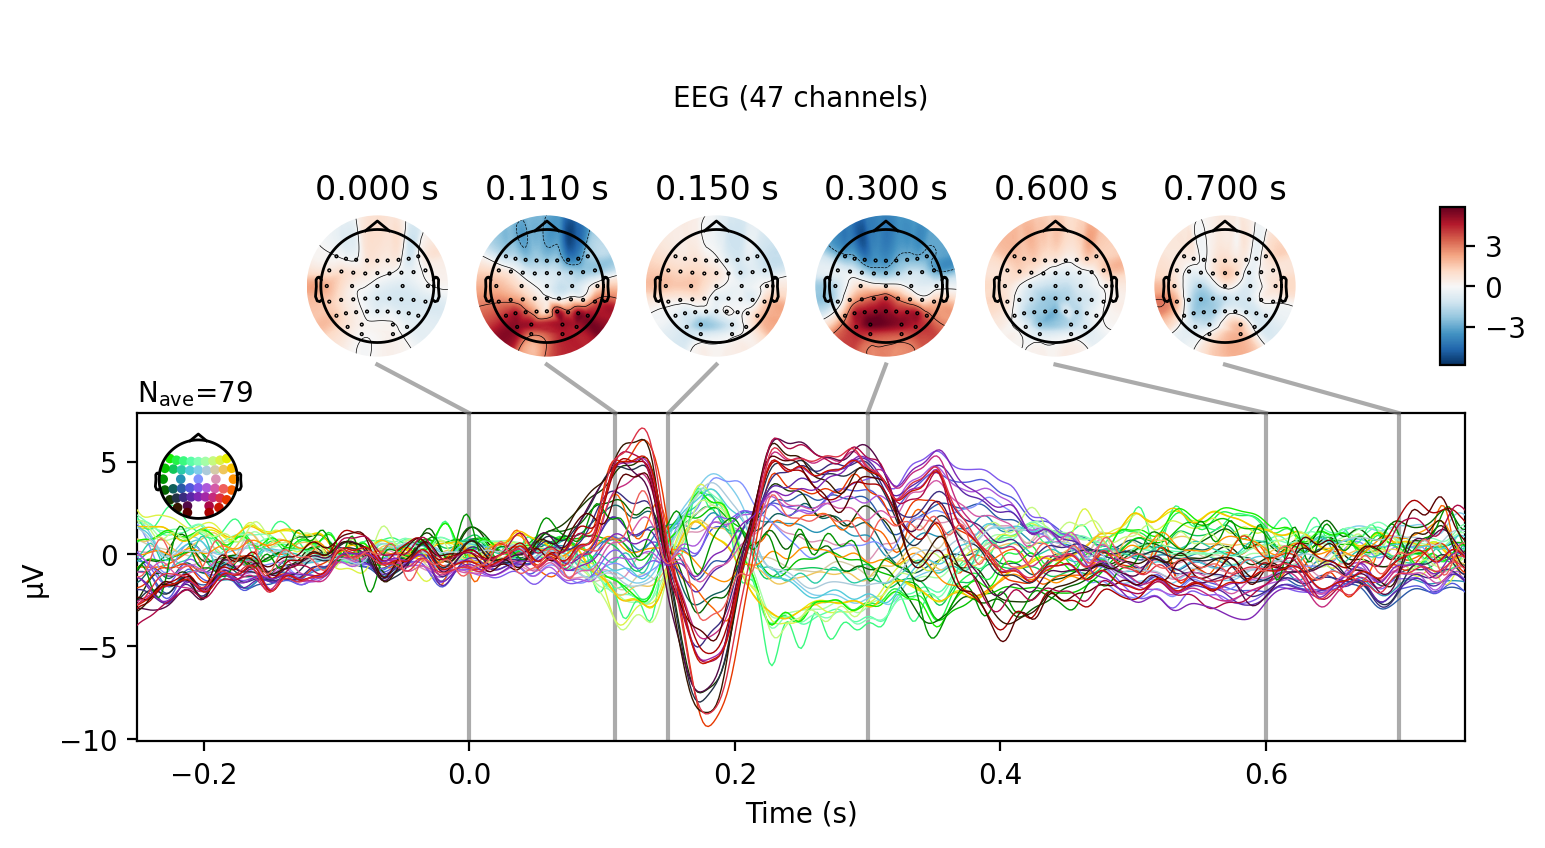

In [63]:
evoked_epoch_1_H.detrend().plot_joint(times=[0.0, 0.11, 0.15, 0.3, 0.6, 0.7])

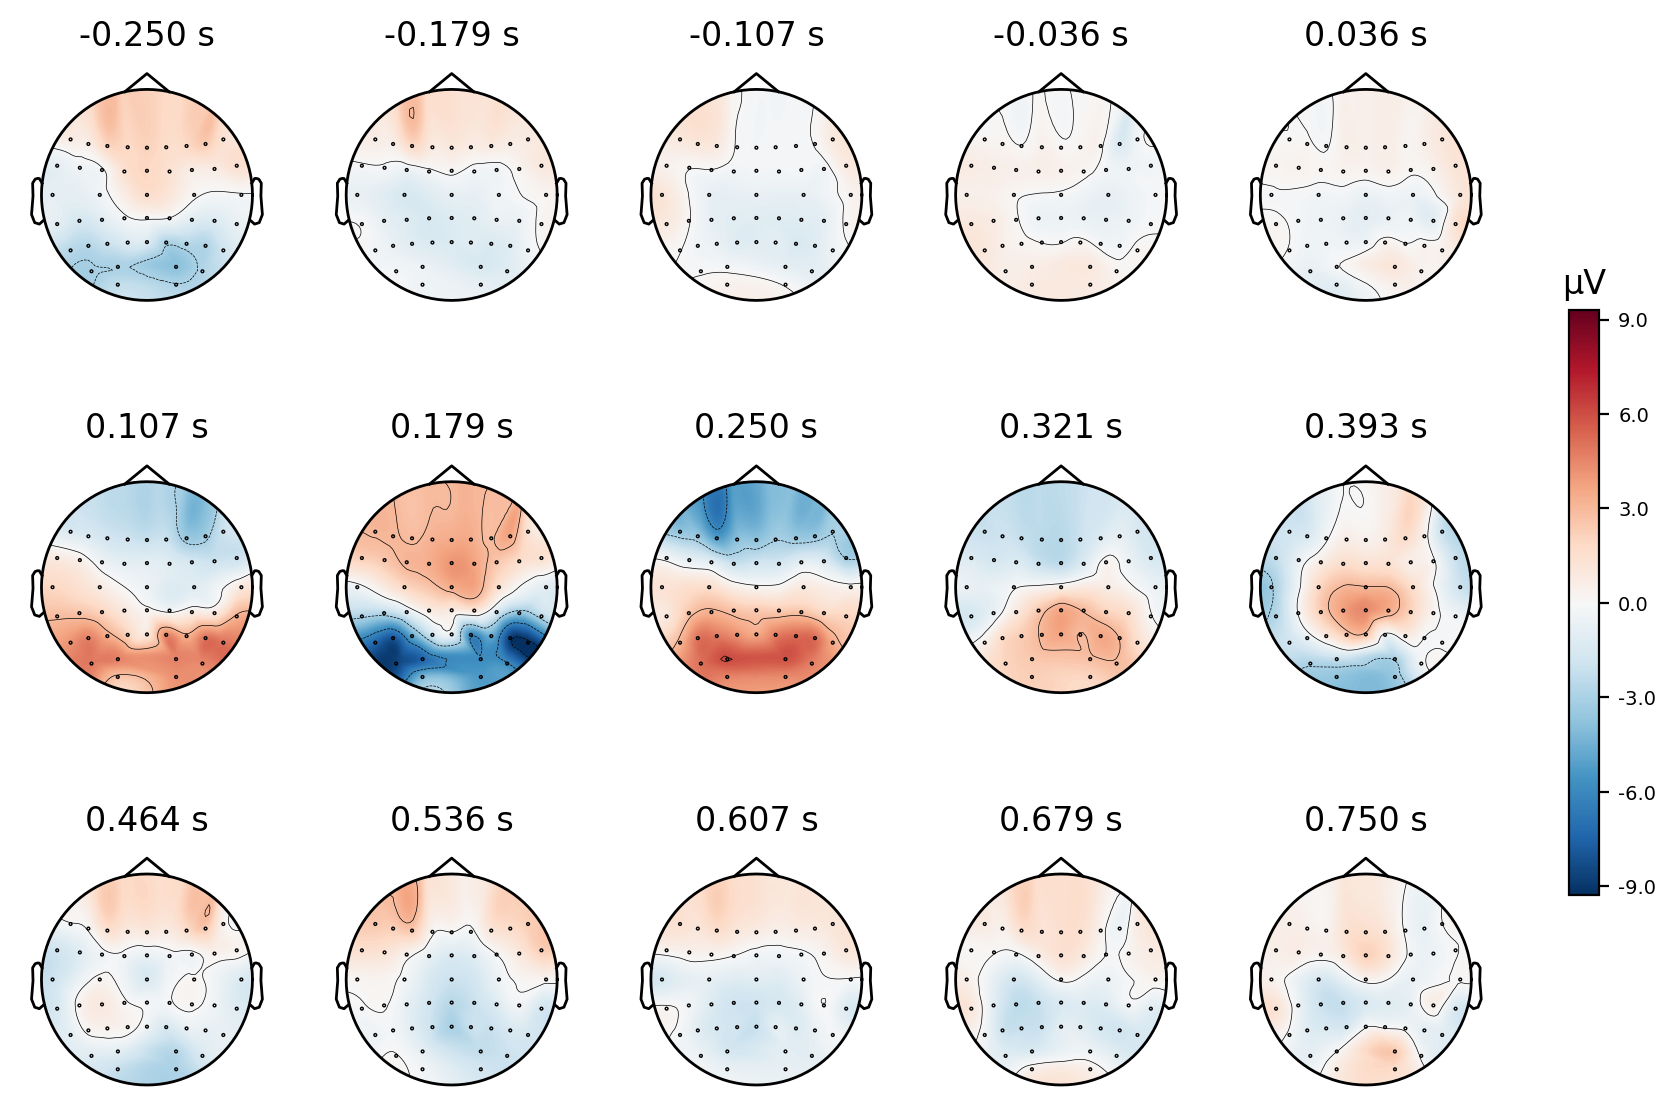

In [64]:
#import numpy as np
times = np.linspace(-0.25, 0.75, 15)
evoked_epoch_1_H.plot_topomap(times=times, ch_type='eeg', nrows=3,)
#fig.savefig('evoked_10_topomap.png', dpi=200)

In [ ]:
fig, anim = evoked_epoch_1_H.animate_topomap(
    times=times, ch_type='eeg', frame_rate=2, time_unit='s', blit=False, butterfly=True, show=True)

#### Combining Evoked

In [67]:
def custom_func(x):
    return x.max(axis=1)


for combine in ('mean', 'median', custom_func):
    mne.viz.plot_compare_evokeds([evoked_H, evoked_L], picks='eeg', combine=combine)

combining channels using "mean"
combining channels using "mean"
combining channels using "median"
combining channels using "median"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "<function custom_func at 0x7fa6778cef80>"
combining channels using "<function custom_func at 0x7fa6778cef80>"


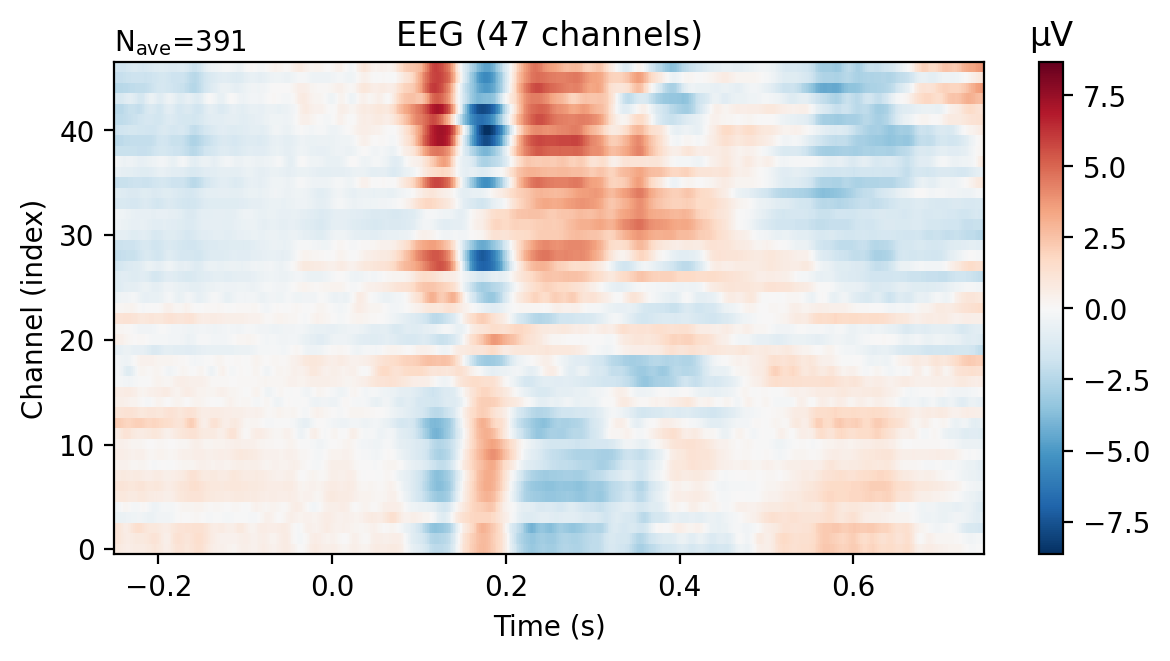

In [68]:
# plot topography per row (one channel per row)
evoked_H.plot_image()

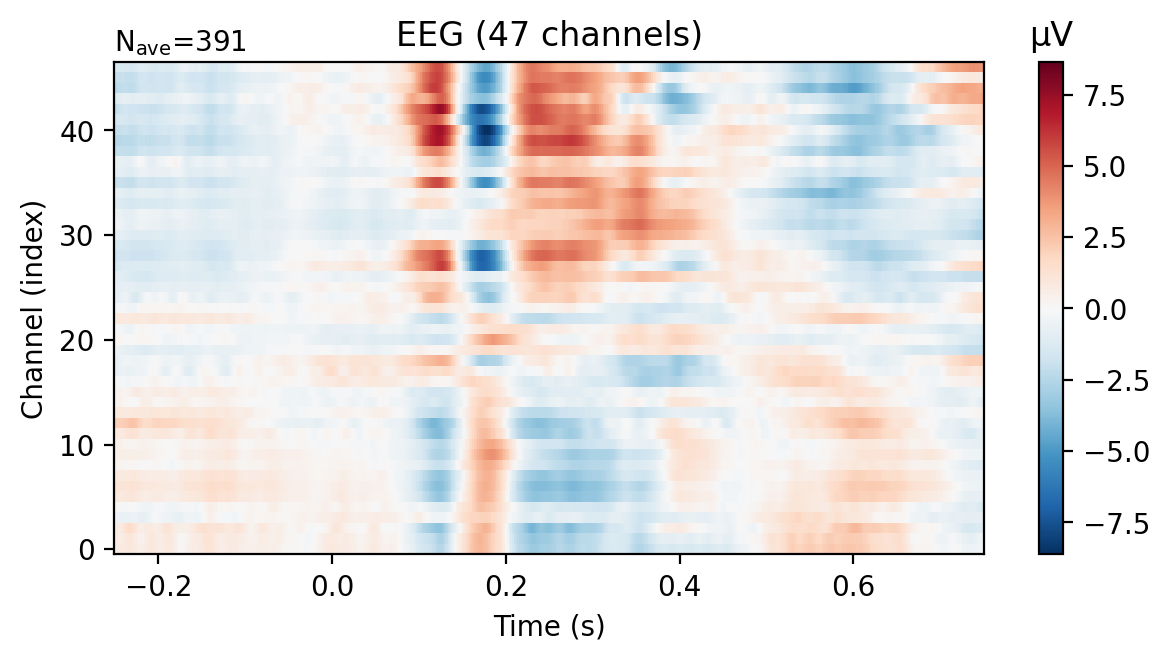

In [69]:
evoked_L.plot_image()

## Power

In [70]:
freqs = np.arange(4.0, 45.5, 0.5)
freqs

array([ 4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,
        9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5,
       15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ,
       20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5,
       26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. ,
       31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5,
       37. , 37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. ,
       42.5, 43. , 43.5, 44. , 44.5, 45. ])

In [72]:
power_H, itc_H = mne.time_frequency.tfr_morlet(epochs_evoked["triplet == 'H'"],
                                               freqs=freqs,
                                               n_cycles=freqs/2,
                                               return_itc=True, # use average=True to return ITC
                                               decim=1,
                                               average=True,
                                               n_jobs=8)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   26.5s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:  1.1min finished


In [73]:
power_f_corrected = np.zeros_like(power_H.data)
# divide power by 1/f
for e in range(power_H.data.shape[0]):
    for f in range(power_H.data.shape[1]):
        power_f_corrected[e][f] = power_H.data[e][f] / (1/power_H.freqs[f])

power_H.data = power_f_corrected

Applying baseline correction (mode: logratio)


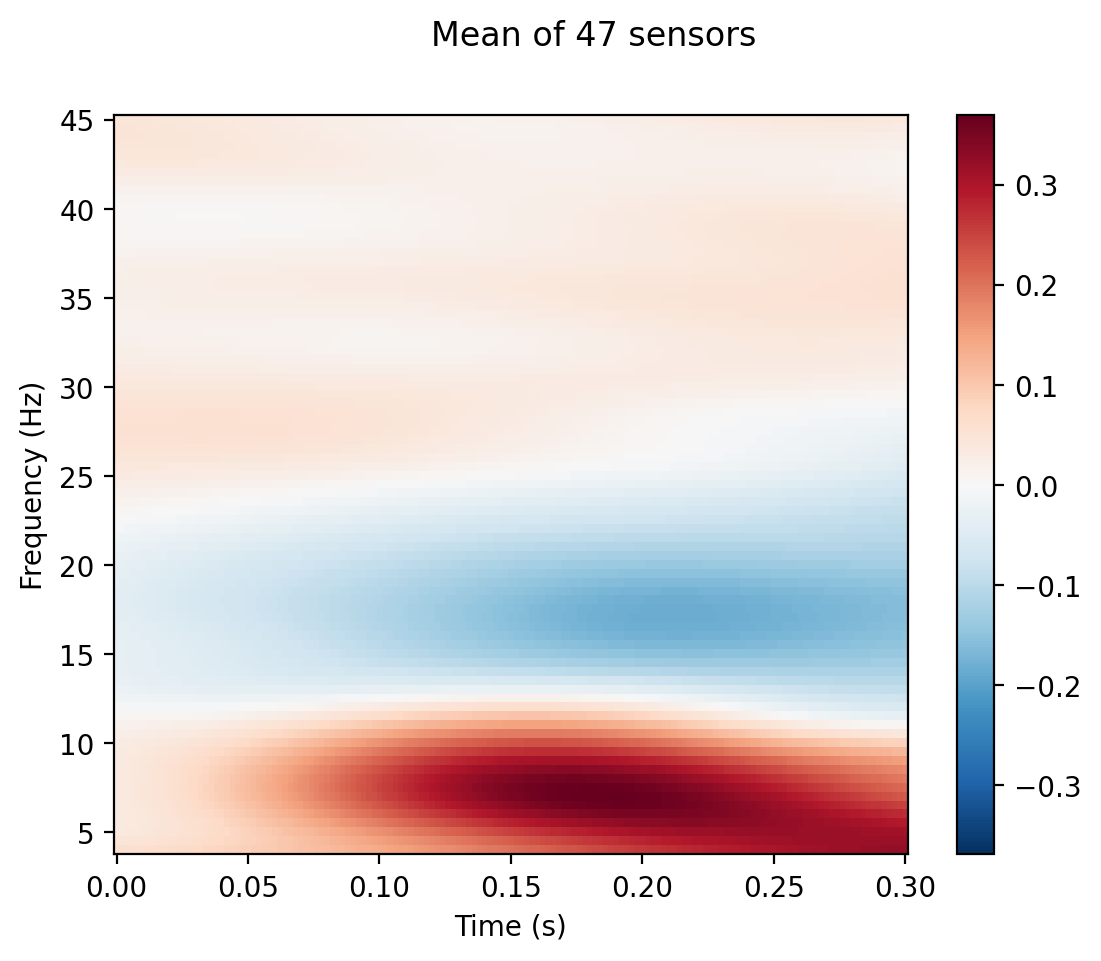

No baseline correction applied


In [75]:
power_H.plot(baseline=(-0.25,0.0), mode='logratio', combine='mean', tmin=0.0, tmax=0.3)

Applying baseline correction (mode: logratio)


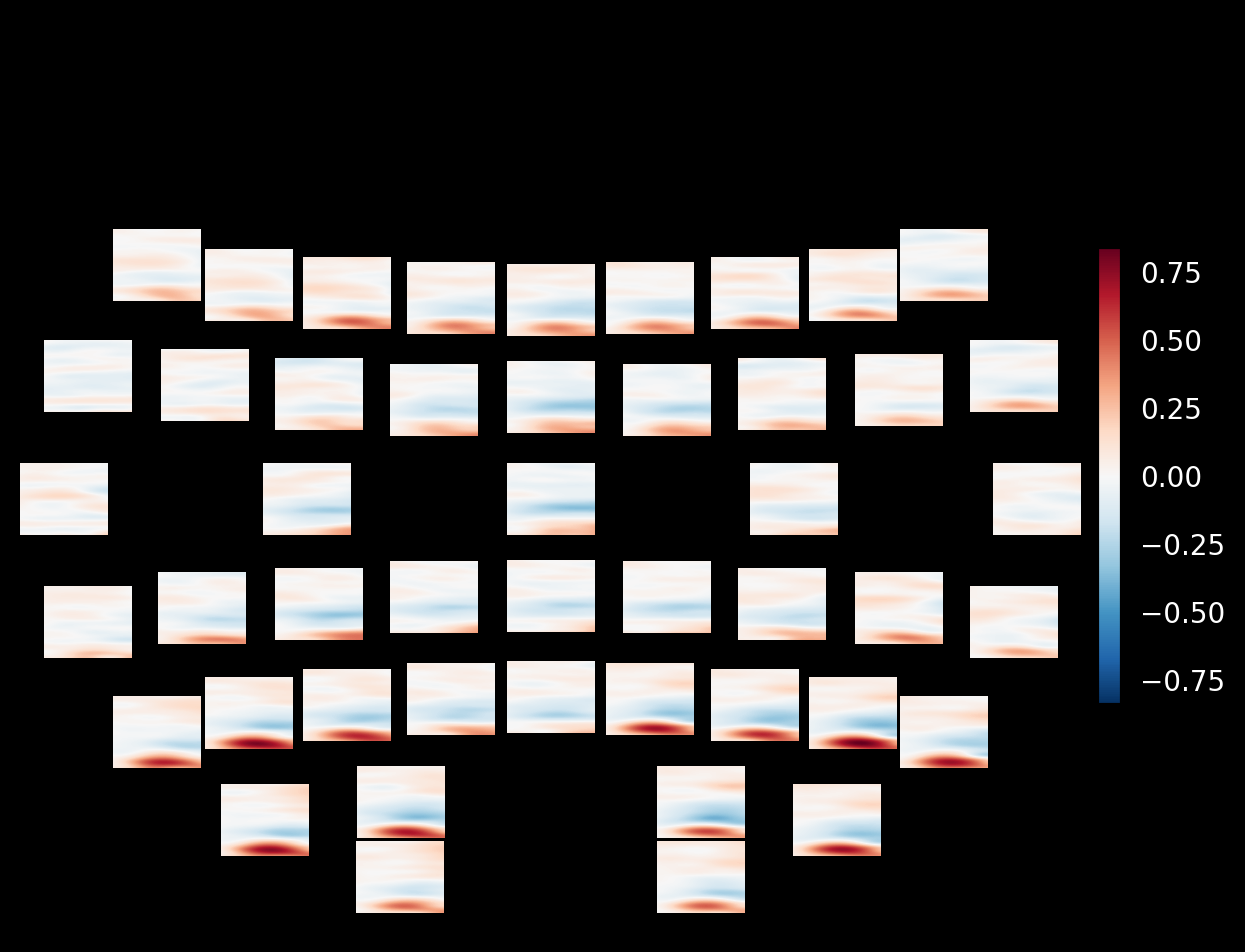

/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [77]:
power_H.plot_topo(baseline=(-0.25,0.0), mode='logratio', tmin=0.0, tmax=0.30)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


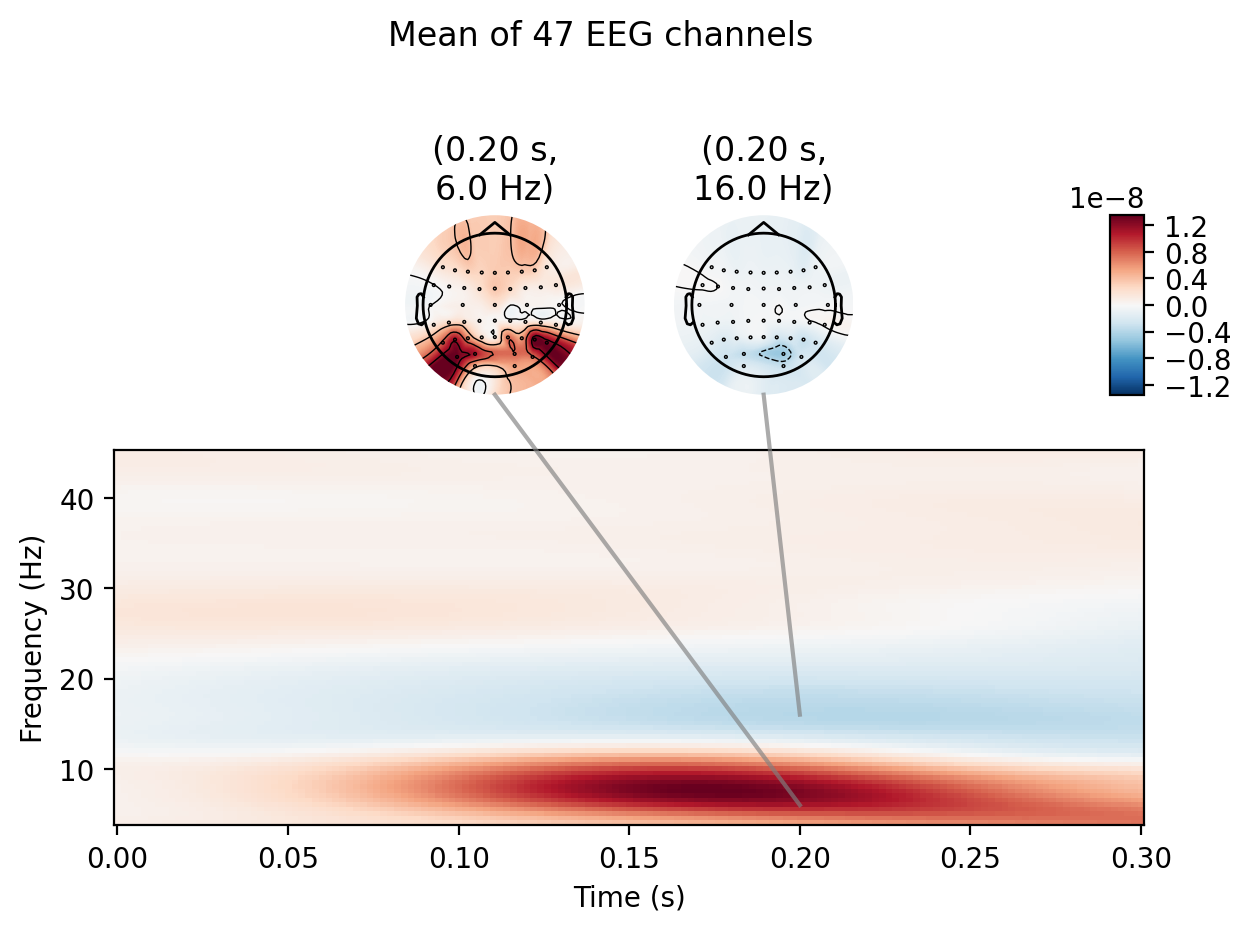

In [89]:
power_H.plot_joint(baseline=(-0.25, 0), mode='mean', tmin=0.0, tmax=0.3, timefreqs=[(0.2, 6), (0.2, 16)])

In [82]:
power_H.plot_joint?

No baseline correction applied


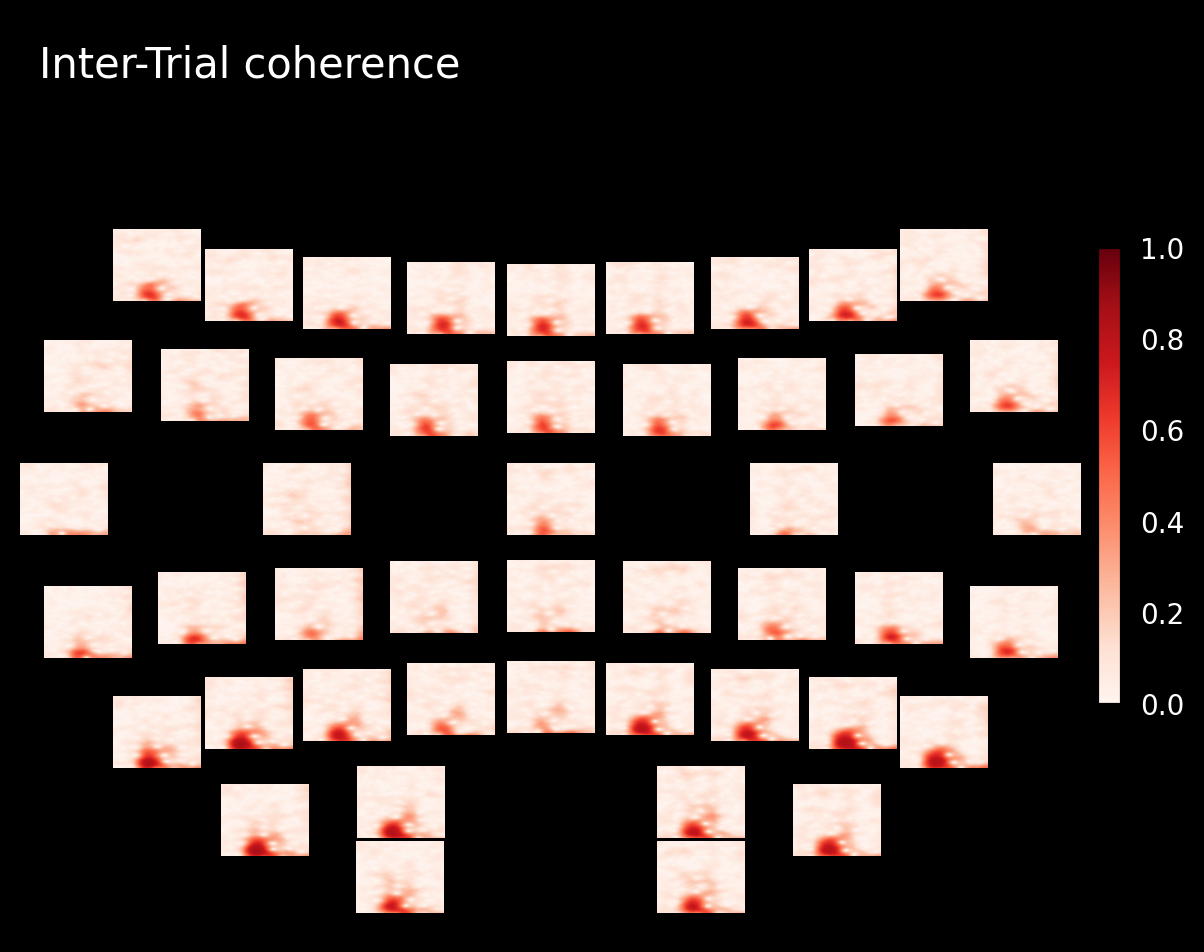

/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:224: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [92]:
itc_H.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')